<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/ImageWoof_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 4.4 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 37.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is inco

In [2]:
import fastai
print(fastai.__version__)

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

2.0.19
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastcore.foundation import L

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fit_one_cycle

from fastai.data.core import Datasets, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import IntToFloatTensor, Normalize, ToTensor, IndexSplitter, get_image_files, parent_label, Categorize

from fastai.metrics import accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.learner import cnn_learner

import random

from sklearn.model_selection import StratifiedKFold

from torchvision.models.resnet import resnet34

In [4]:
path = untar_data(URLs.IMAGEWOOF)

File downloaded is broken. Remove /root/.fastai/archive/imagewoof2.tgz and try again.


In [5]:
path.ls()

(#3) [Path('/root/.fastai/data/imagewoof2/train'),Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/noisy_imagewoof.csv')]

In [6]:
item_tfms = [ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))]
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [7]:
train_imgs = get_image_files(path/'train')
tst_imgs = get_image_files(path/'val')

In [8]:
random.shuffle(train_imgs)

In [9]:
len(train_imgs)

9025

In [10]:
len(tst_imgs)

3929

In [11]:
train_imgs[:5]

(#5) [Path('/root/.fastai/data/imagewoof2/train/n02105641/n02105641_13009.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02089973/n02089973_4084.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02089973/n02089973_5906.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02086240/n02086240_6477.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02099601/n02099601_3043.JPEG')]

In [12]:
start_val = len(train_imgs) - int(len(train_imgs)*.2)
idxs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idxs)
splits = splitter(train_imgs)

In [13]:
splits

((#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...])

In [14]:
split_list = [splits[0], splits[1]]
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...]]

In [15]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

train, valid, test

In [16]:
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...],
 (#3929) [9025,9026,9027,9028,9029,9030,9031,9032,9033,9034...]]

In [17]:
L(range(len(train_imgs)))

(#9025) [0,1,2,3,4,5,6,7,8,9...]

In [18]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

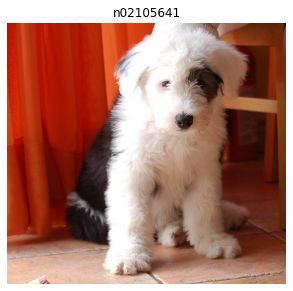

In [19]:
show_at(dsrc.train, 8)

In [20]:
dsrc.n_subsets

3

In [21]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

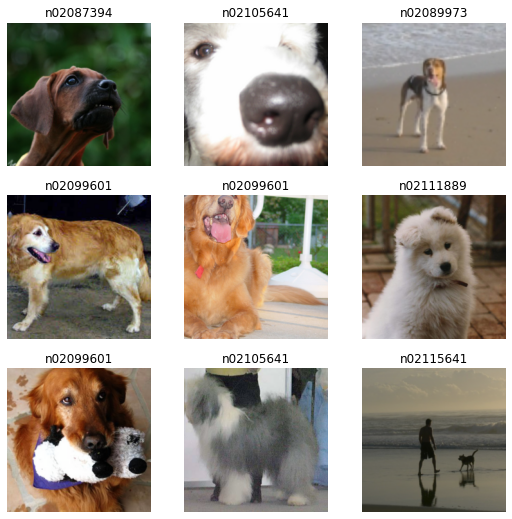

In [22]:
dls.show_batch()

In [23]:
dls.n_subsets

3

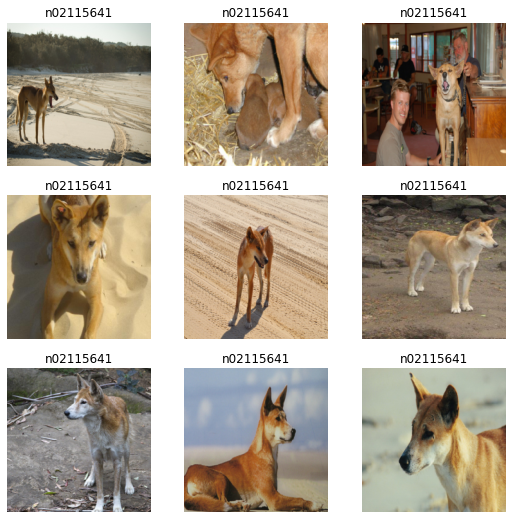

In [24]:
dls[2].show_batch()

In [25]:
learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy).to_fp16()

In [26]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

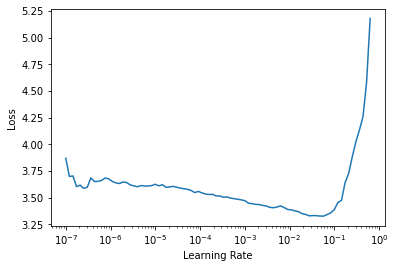

In [27]:
lr_min,lr_steep = learn.lr_find()

In [28]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 1.45e-05


In [29]:
learn.fit_one_cycle(1, lr_max=5.75e-03)

epoch,train_loss,valid_loss,accuracy,time
0,2.612638,2.150608,0.219945,01:57


In [30]:
learn.validate(ds_idx=2)

(#2) [2.133052349090576,0.2293204367160797]

In [31]:
from sklearn.model_selection import StratifiedKFold

In [39]:
train_labels = L(dsrc.items).map(dsrc.tfms[1])

In [43]:
train_labels

(#12954) [TensorCategory(7),TensorCategory(3),TensorCategory(3),TensorCategory(0),TensorCategory(6),TensorCategory(4),TensorCategory(5),TensorCategory(0),TensorCategory(7),TensorCategory(2)...]

In [40]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [41]:
n_splits = 10

In [42]:
import random
random.shuffle(train_imgs)

In [ ]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)

for _, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):

  splits = IndexSplitter(val_idx)
  split = splits(train_imgs)
  split_list = [split[0], split[1]]
  split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

  dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]], splits=split_list)
  dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

  learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy)
  learn.fit_one_cycle(1)
  
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=2)
  tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,2.752724,2.136521,0.204554,02:06


epoch,train_loss,valid_loss,accuracy,time
